## Library imports

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *
import torch as t
from chromatography import placement_error, overlap_error, ExperimentAnalytes

sns.set(style="darkgrid", rc={'figure.figsize':(11.7,18.27)})
%matplotlib inline

## Dataset Import

In [115]:
alist = pd.read_csv('../data/Peter32.csv')

## Useful functions definition

In [116]:
run1 = ExperimentAnalytes(k0 = alist.k0.values, S = alist.S.values, h=0.001, grad='iso', run_time=1)

run1.final_position
phis = [0.37, 0.75, 0.3, 0.09, 0.5]
time = [np.zeros(alist.k0.values.shape)]
positions = [np.zeros(alist.k0.values.shape)]
for phi in phis:
    if phi == 0.5:
        t, p = run1.step(phi, 30)
    else:
        t, p = run1.step(phi, 0.1)
    time.append(t)
    positions.append(p)

In [117]:
def print_analytes(times, positions):
    
    rcParams['figure.figsize'] = 20, 10

    for i in range(len(times)-1):
        for j in range(len(times[i])):
            if i%2:
                col = 'r'
            else:
                col = 'b'
            plot(np.linspace(time[i][j], time[i+1][j], 100), np.linspace(positions[i][j], positions[i+1][j], 100),  
                 c=col)
        

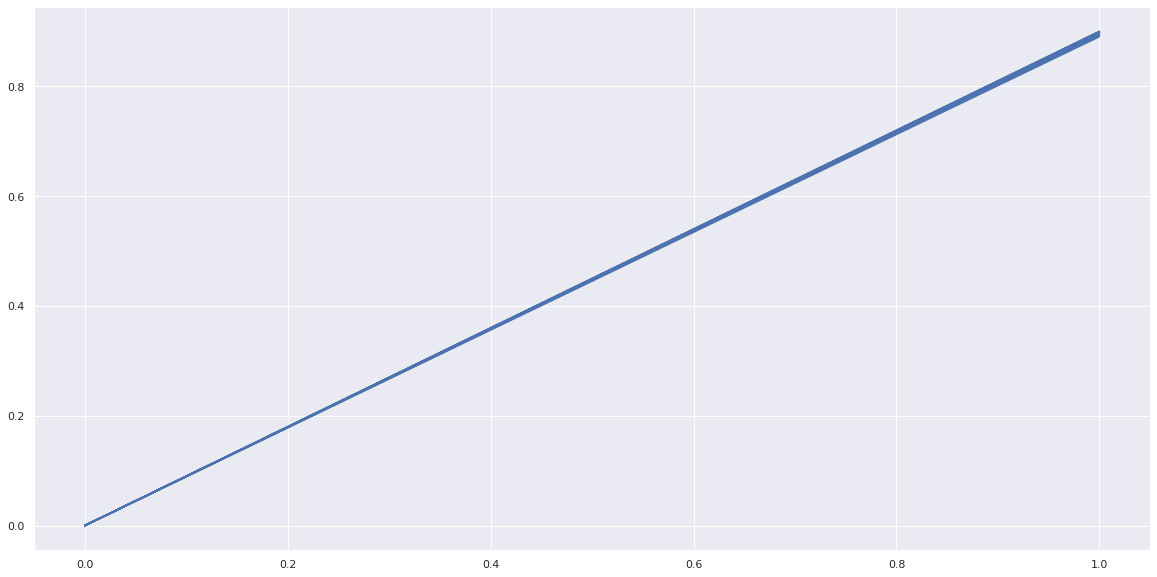

In [118]:
print_analytes(time, positions)

In [119]:
positions

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.8972489 , 0.89828417, 0.89577441, 0.89837539, 0.89988126,
        0.8946937 , 0.89197217, 0.89760524, 0.89889694, 0.8973919 ,
        0.89896872, 0.89711086, 0.89708916, 0.89949778, 0.89640875,
        0.89760887, 0.89962666, 0.89281276, 0.89904681, 0.89757686,
        0.89782785, 0.89990894, 0.89655325, 0.89619258, 0.89467298,
        0.89715078, 0.8901937 , 0.89780442, 0.89762037, 0.89814795,
        0.89824335, 0.89596118]),
 array([0.8972489 , 0.89828417, 0.89577441, 0.89837539, 0.89988126,
        0.8946937 , 0.89197217, 0.89760524, 0.89889694, 0.8973919 ,
        0.89896872, 0.89711086, 0.89708916, 0.89949778, 0.89640875,
        0.89760887, 0.89962666, 0.89281276, 0.89904681, 0.89757686,
        0.89782785, 0.89990894, 0.89655325, 0.89619258, 0.89467298,
        0.89715078, 0.8901937 , 0.89780442, 0.89762037, 0.89814795,
    

In [ ]:
def sig(height, mu):
    return np.sqrt((mu**2) * height)

In [ ]:
def k(k0, S, phi):
    return (10 ** (-phi * S)) * k0

In [ ]:
def xk(k0, S, phi, dt):
    return dt /(k(k0, S, phi) + 1)

In [ ]:
def iso_list(anlist, phi):
    k0 = anlist[:,1]
    S = anlist[:,2]
    dt =  (1 - 2 * np.sqrt(0.001))
    return np.sort(dt /((10 ** (-phi * S)) * k0 + 1))

In [ ]:
def iso_spot(anlist, phi):
    return pl_error(iso_list(anlist, phi))

In [ ]:
def int_(ud, sigd, ua, siga):
    return (2 * siga ** 2 * sigd - 2 * siga * sigd ** 2 \
            + sigd ** 2 * ua + siga ** 2 * ud)\
            / ( siga ** 2 + sigd ** 2)

In [ ]:
def bl(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ua - 2 * siga
    return np.stack([first,second], axis=1).max(axis=1)

In [ ]:
def bu(ud, sigd, ua, siga):
    first = int_(ud, sigd, ua, siga)
    second = ud + 2 * sigd
    return np.stack([first,second], axis=1).min(axis=1)

In [ ]:
def cushlist(res_list):
    return np.concatenate([ np.array([
        0, 10 ** -10]).reshape(1, -1),
        res_list,
        np.array([1, 10 ** -10]).reshape(1, -1)])

In [ ]:
def poi(res_list):
    return np.stack(
        [
            bl(res_list[:-2, 0], res_list[:-2, 1], res_list[1:-1, 0], res_list[1:-1, 1]),
            res_list[1:-1, 0],
            bu(res_list[1:-1, 0], res_list[1:-1, 1], res_list[2:, 0], res_list[2:, 1])
        ],
        axis=1
       )

In [ ]:
def yval(x_list, chrom):

    denominator = 4 * chrom[:, 1] ** 2
    temp_1 = np.abs(x_list[:, 0] - x_list[:, 1])
    temp_1[temp_1 > chrom[:, 1]] = 0
    temp_1 /= denominator
    
    temp_2 = 1/(2 * chrom[:, 1])
    
    temp_3 = np.abs(x_list[:, 1] - x_list[:, 1])
    temp_3[np.abs(x_list[:, 2] - x_list[:, 1]) > chrom[:, 1]] = 0
    temp_3 /= denominator
    
    return np.stack([temp_1, temp_2, temp_3], axis=1)


In [ ]:
def narea(main_list, x_list, y_list):
    return 1 - ((y_list[:, 1] - y_list[:, 0])*(x_list[:, 1] - x_list[:, 0])
            - (y_list[:, 2] - y_list[:, 1])*(x_list[:, 2] - x_list[:, 1])).sum()/(2 * main_list.shape[0])

In [ ]:
def lfn(main_list, x_list, y_list):
    return plerror(main_list) + narea(main_list, x_list, y_list)

In [ ]:
def isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    padlist = cushlist(schroma)
    npoi = poi(padlist)
    ypoi = yval(npoi, schroma)
    lofn = placement_error(schroma[:,0]) + narea(schroma,npoi, ypoi)
    
    return chroma, schroma, narea(schroma,npoi, ypoi)

In [ ]:
phis = np.linspace(0.001, 0.999, 999)

In [ ]:
def loss_suhas():
    _, data, _ = isoloss(alist, 0.34, 0.001)
    return data
data = loss_suhas()

In [ ]:
sns.relplot(x='phi', y='loss', data=data, kind='line')
plt.ylim(0, 2)
plt.show()

In [ ]:
def my_isoloss(alist, phi, h):
    chroma = iso_list(alist.values, phi)
    chroma = np.array([chroma, sig(h, chroma)]).T
    schroma = chroma[chroma[:,0].argsort()]
    lofn = placement_error(schroma[:,0]) + overlap_error(schroma[:,0], schroma[:,1])
    
    return chroma, schroma, lofn

In [ ]:
plt.rcParams['figure.figsize'] = (16,8)
for mu, sigma in b:
    x = np.random.normal(mu, sigma, size=500)
    sns.kdeplot(x, shade=True)
    plt.xlim((0,1))

In [ ]:
def my_loss():
    for phi in phis:
        my_isoloss(alist, phi, 0.001)


In [ ]:
sns.relplot(x='phi', y='loss', data=data, kind='line')
plt.ylim(0, 2)
plt.show()

In [ ]:
data.sort_values('loss')

In [ ]:
%timeit  isoloss(alist, 0.34, 0.001)

In [ ]:
%timeit  my_isoloss(alist, 0.34, 0.001)

In [ ]:
0.015625*1000